In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.attributes.log import get as attributes_get
import warnings
warnings.filterwarnings('ignore')

In [3]:
# STEP 1: Enhanced Data Preprocessing
# ===============================

# Load and preprocess data (your existing code with improvements)
df = pd.read_csv("incidentProcess_customf.csv", dtype=str, low_memory=False)
df = df[df["Incident ID"].notna() & df["Activity"].notna()]
df["ActivityTimeStamp"] = pd.to_datetime(df["ActivityTimeStamp"], errors="coerce")
df = df.dropna(subset=["ActivityTimeStamp"])

# Enhanced column mapping
df.rename(columns={
    "Incident ID": "case:concept:name",
    "Activity": "concept:name",
    "ActivityTimeStamp": "time:timestamp",
    "Assignment Group": "org:group"
}, inplace=True)

# Convert timestamps properly
df = dataframe_utils.convert_timestamp_columns_in_df(df)

# Convert to event log
log = log_converter.apply(df)

print("Data loaded and preprocessed successfully!")
print(f"Total events: {len(df)}")
print(f"Total cases: {df['case:concept:name'].nunique()}")
print(f"Total activities: {df['concept:name'].nunique()}")

Data loaded and preprocessed successfully!
Total events: 120221
Total cases: 37813
Total activities: 18


In [4]:
# STEP 2: Comprehensive Reassignment Analysis
# ===============================

def analyze_reassignments(df):
    """Comprehensive reassignment analysis"""
    
    # Identify reassignment activities
    reassignment_keywords = ['Assign to', 'Reassign', 'Transfer', 'Escalate']
    df['IsReassignment'] = df['concept:name'].str.contains('|'.join(reassignment_keywords), case=False, na=False)
    
    # Count reassignments per case
    reassign_counts = df[df['IsReassignment']].groupby('case:concept:name').agg({
        'IsReassignment': 'sum',
        'org:group': lambda x: list(x.unique())  # Track teams involved
    }).reset_index()
    
    reassign_counts.columns = ['case:concept:name', 'ReassignmentCount', 'TeamsInvolved']
    reassign_counts['NumTeamsInvolved'] = reassign_counts['TeamsInvolved'].apply(len)
    
    return reassign_counts

def get_resolution_metrics(df):
    """Extract resolution time and other performance metrics"""
    
    # Get unique case information
    case_info = df.groupby('case:concept:name').agg({
        'Open Time': 'first',
        'Resolved Time': 'first',
        'Close Time': 'first',
        'Handle Time (Hours)': 'first',
        'Priority': 'first',
        'Impact': 'first',
        'Urgency': 'first',
        'Status': 'first'
    }).reset_index()
    
    # Convert time columns
    for col in ['Open Time', 'Resolved Time', 'Close Time']:
        case_info[col] = pd.to_datetime(case_info[col], errors='coerce')
    
    # Calculate resolution time in hours
    case_info['ResolutionTimeHours'] = (case_info['Resolved Time'] - case_info['Open Time']).dt.total_seconds() / 3600
    case_info['Handle Time (Hours)'] = pd.to_numeric(case_info['Handle Time (Hours)'], errors='coerce')
    
    return case_info

# Perform analysis
reassign_analysis = analyze_reassignments(df)
resolution_metrics = get_resolution_metrics(df)

# Merge datasets
complete_analysis = pd.merge(reassign_analysis, resolution_metrics, on='case:concept:name', how='inner')
complete_analysis = complete_analysis[complete_analysis['ResolutionTimeHours'] >= 0]

print(f"\nReassignment Analysis Summary:")
print(f"Cases with reassignments: {len(complete_analysis[complete_analysis['ReassignmentCount'] > 0])}")
print(f"Average reassignments per case: {complete_analysis['ReassignmentCount'].mean():.2f}")
print(f"Max reassignments: {complete_analysis['ReassignmentCount'].max()}")


Reassignment Analysis Summary:
Cases with reassignments: 20353
Average reassignments per case: 2.22
Max reassignments: 46


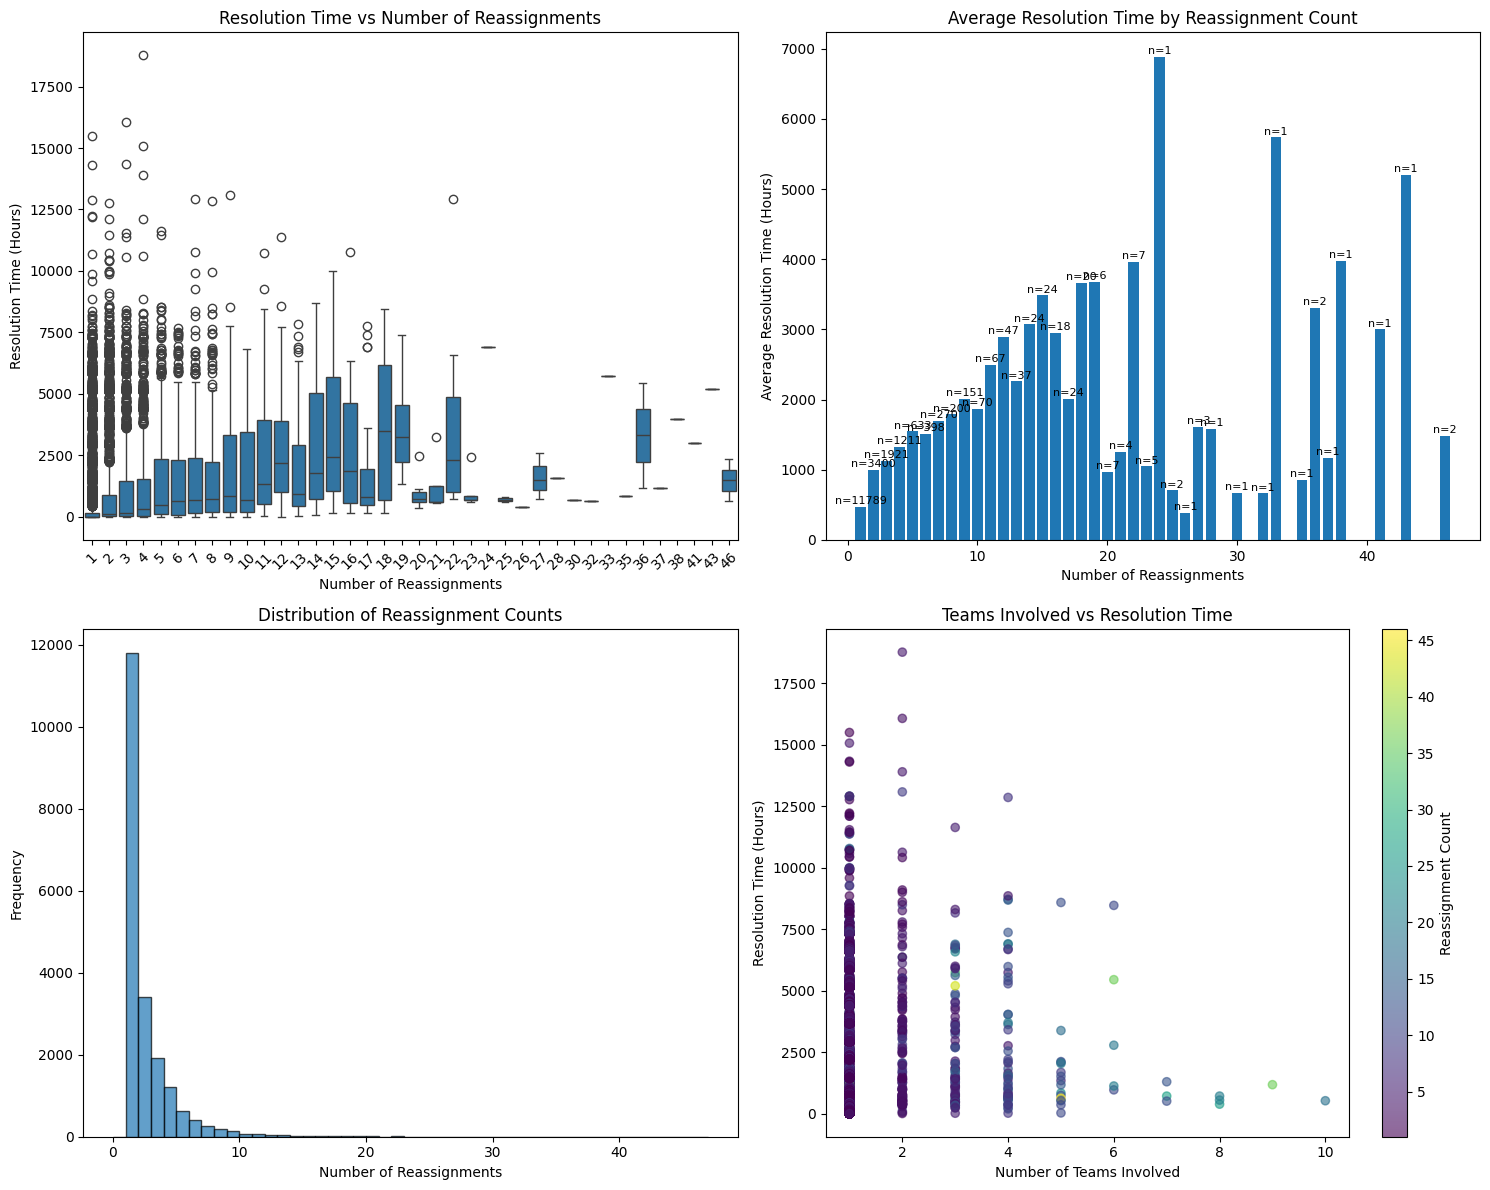

In [5]:
# STEP 3: Pattern Analysis and Visualization
# ===============================

def create_reassignment_visualizations(data):
    """Create comprehensive visualizations"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Boxplot: Resolution Time vs Reassignment Count
    sns.boxplot(data=data, x='ReassignmentCount', y='ResolutionTimeHours', ax=axes[0,0])
    axes[0,0].set_title('Resolution Time vs Number of Reassignments')
    axes[0,0].set_xlabel('Number of Reassignments')
    axes[0,0].set_ylabel('Resolution Time (Hours)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Bar chart: Average Resolution Time by Reassignment Count
    avg_resolution = data.groupby('ReassignmentCount')['ResolutionTimeHours'].agg(['mean', 'count']).reset_index()
    avg_resolution = avg_resolution[avg_resolution['count'] >= 1]  # Only show groups with 5+ cases
    
    bars = axes[0,1].bar(avg_resolution['ReassignmentCount'], avg_resolution['mean'])
    axes[0,1].set_title('Average Resolution Time by Reassignment Count')
    axes[0,1].set_xlabel('Number of Reassignments')
    axes[0,1].set_ylabel('Average Resolution Time (Hours)')
    
    # Add count labels on bars
    for bar, count in zip(bars, avg_resolution['count']):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                      f'n={count}', ha='center', va='bottom', fontsize=8)
    
    # 3. Histogram: Distribution of Reassignments
    axes[1,0].hist(data['ReassignmentCount'], bins=range(0, data['ReassignmentCount'].max()+2), 
                   alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribution of Reassignment Counts')
    axes[1,0].set_xlabel('Number of Reassignments')
    axes[1,0].set_ylabel('Frequency')
    
    # 4. Scatter plot: Teams Involved vs Resolution Time
    scatter = axes[1,1].scatter(data['NumTeamsInvolved'], data['ResolutionTimeHours'], 
                               c=data['ReassignmentCount'], cmap='viridis', alpha=0.6)
    axes[1,1].set_title('Teams Involved vs Resolution Time')
    axes[1,1].set_xlabel('Number of Teams Involved')
    axes[1,1].set_ylabel('Resolution Time (Hours)')
    plt.colorbar(scatter, ax=axes[1,1], label='Reassignment Count')
    
    plt.tight_layout()
    plt.show()

create_reassignment_visualizations(complete_analysis)


In [6]:
# ===============================
# STEP 4: Process Variant Analysis
# ===============================

def analyze_process_variants(log, df):
    """Analyze different process variants and their performance"""
    
    # Get variant statistics
    variants_count = case_statistics.get_variant_statistics(log)
    variants_count = sorted(variants_count, key=lambda x: int(x["count"]), reverse=True)
    
    print(f"\nTop 10 Process Variants:")
    print("-" * 80)
    
    variant_analysis = []
    
    for i, variant in enumerate(variants_count[:10]):
        variant_trace = variant['variant']
        variant_count = int(variant['count'])
        
        # Count reassignments in this variant
        reassign_count = sum(1 for activity in variant_trace if 'Assign' in activity)
        
        # Get cases following this variant
        variant_cases = []
        for trace in log:
            trace_activities = tuple([event['concept:name'] for event in trace])
            if trace_activities == variant_trace:
                variant_cases.append(trace.attributes['concept:name'])
        
        # Calculate average resolution time for this variant
        variant_data = complete_analysis[complete_analysis['case:concept:name'].isin(variant_cases)]
        avg_resolution = variant_data['ResolutionTimeHours'].mean() if len(variant_data) > 0 else 0
        
        variant_info = {
            'Rank': i+1,
            'Variant': ' → '.join(variant_trace[:3]) + ('...' if len(variant_trace) > 3 else ''),
            'Count': variant_count,
            'Reassignments': reassign_count,
            'Avg_Resolution_Hours': avg_resolution,
            'Full_Trace': variant_trace
        }
        
        variant_analysis.append(variant_info)
        
        print(f"{i+1:2d}. Count: {variant_count:3d} | Reassigns: {reassign_count:2d} | "
              f"Avg Resolution: {avg_resolution:6.1f}h | {variant_info['Variant']}")
    
    return pd.DataFrame(variant_analysis)

variant_df = analyze_process_variants(log, df)


Top 10 Process Variants:
--------------------------------------------------------------------------------
 1. Count: 4507 | Reassigns:  0 | Avg Resolution:    0.0h | Open
 2. Count: 2924 | Reassigns:  1 | Avg Resolution:  415.6h | Assign to 1st Line Operator
 3. Count: 2298 | Reassigns:  1 | Avg Resolution:  360.2h | Open → Assign to 1st Line Operator
 4. Count: 2262 | Reassigns:  0 | Avg Resolution:    0.0h | Close → Set Asset Caused
 5. Count: 1553 | Reassigns:  0 | Avg Resolution:    0.0h | Set Asset Caused → Close
 6. Count: 1317 | Reassigns:  0 | Avg Resolution:    0.0h | Open → Close → Set Asset Caused
 7. Count: 878 | Reassigns:  1 | Avg Resolution:  395.1h | Assign to 1st Line Operator → Close → Set Asset Caused
 8. Count: 752 | Reassigns:  0 | Avg Resolution:    0.0h | Close
 9. Count: 744 | Reassigns:  0 | Avg Resolution:    0.0h | Open → Set Asset Caused → Close
10. Count: 712 | Reassigns:  1 | Avg Resolution:  382.2h | Open → Assign to 1st Line Operator → Close...



Top 10 Handover Patterns:
--------------------------------------------------
TEAM0002 → TEAM0003: 126 times
TEAM0003 → TEAM0002: 122 times
TEAM0008 → TEAM9999: 52 times
TEAM9999 → TEAM0008: 40 times
TEAM0027 → TEAM0015: 35 times
TEAM0007 → TEAM0008: 34 times
TEAM0015 → TEAM0027: 31 times
TEAM0086 → TEAM0008: 26 times
TEAM0008 → TEAM0086: 23 times
TEAM0008 → TEAM0007: 22 times


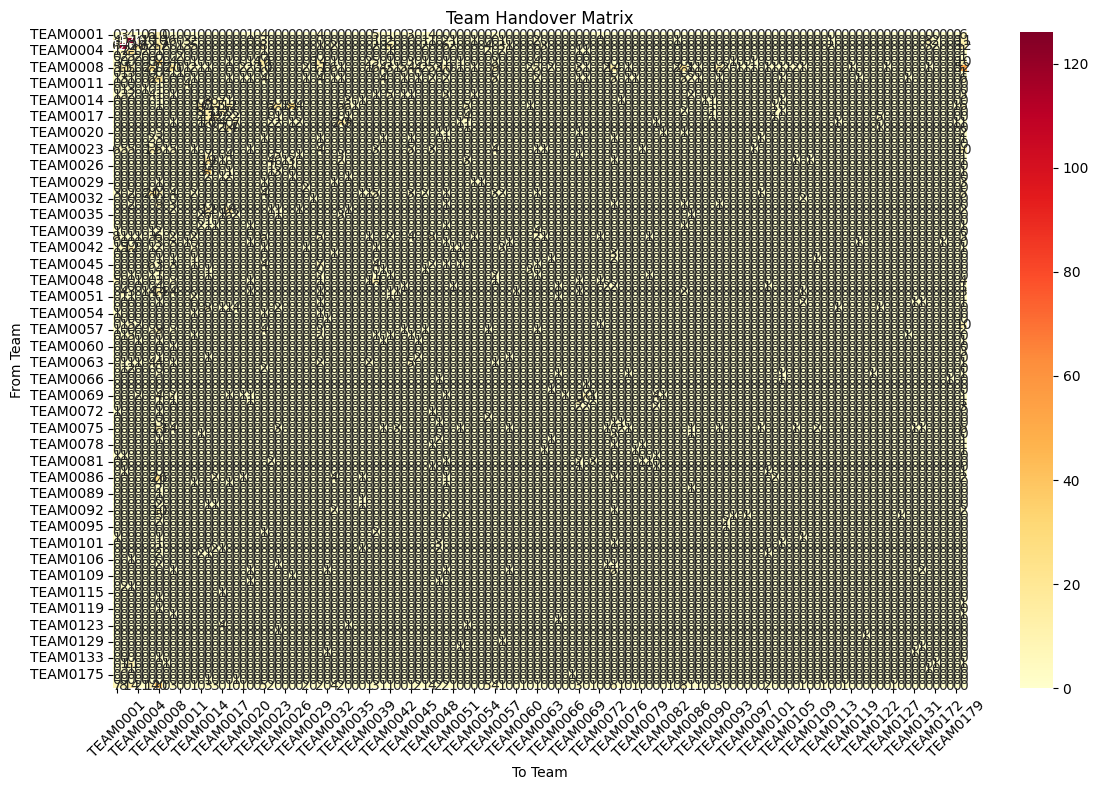

In [7]:
# ===============================
# STEP 5: Handover Analysis
# ===============================

def analyze_handovers(df):
    """Analyze handovers between teams"""
    
    # Sort by case and timestamp
    df_sorted = df.sort_values(['case:concept:name', 'time:timestamp'])
    
    # Identify handovers (when assignment group changes)
    handovers = []
    
    for case_id in df_sorted['case:concept:name'].unique():
        case_data = df_sorted[df_sorted['case:concept:name'] == case_id]
        
        prev_group = None
        for _, row in case_data.iterrows():
            current_group = row['org:group']
            if prev_group and prev_group != current_group and pd.notna(current_group):
                handovers.append({
                    'case_id': case_id,
                    'from_team': prev_group,
                    'to_team': current_group,
                    'activity': row['concept:name']
                })
            if pd.notna(current_group):
                prev_group = current_group
    
    handover_df = pd.DataFrame(handovers)
    
    if len(handover_df) > 0:
        # Analyze most common handover patterns
        handover_patterns = handover_df.groupby(['from_team', 'to_team']).size().reset_index(name='count')
        handover_patterns = handover_patterns.sort_values('count', ascending=False)
        
        print(f"\nTop 10 Handover Patterns:")
        print("-" * 50)
        for _, row in handover_patterns.head(10).iterrows():
            print(f"{row['from_team']} → {row['to_team']}: {row['count']} times")
        
        # Visualize handover matrix
        handover_matrix = handover_patterns.pivot(index='from_team', columns='to_team', values='count').fillna(0)
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(handover_matrix, annot=True, fmt='g', cmap='YlOrRd')
        plt.title('Team Handover Matrix')
        plt.xlabel('To Team')
        plt.ylabel('From Team')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        return handover_df, handover_patterns
    else:
        print("No handovers detected in the data")
        return pd.DataFrame(), pd.DataFrame()

handover_data, handover_patterns = analyze_handovers(df)

In [8]:
# STEP 6: Statistical Analysis
# ===============================

def statistical_analysis(data):
    """Perform statistical analysis on reassignment impact"""
    
    from scipy import stats
    
    print(f"\nStatistical Analysis:")
    print("=" * 50)
    
    # Correlation analysis
    corr_reassign_time = data['ReassignmentCount'].corr(data['ResolutionTimeHours'])
    corr_teams_time = data['NumTeamsInvolved'].corr(data['ResolutionTimeHours'])
    
    print(f"Correlation between Reassignments and Resolution Time: {corr_reassign_time:.3f}")
    print(f"Correlation between Teams Involved and Resolution Time: {corr_teams_time:.3f}")
    
    # Compare groups with different reassignment levels
    no_reassign = data[data['ReassignmentCount'] == 0]['ResolutionTimeHours']
    low_reassign = data[(data['ReassignmentCount'] >= 1) & (data['ReassignmentCount'] <= 2)]['ResolutionTimeHours']
    high_reassign = data[data['ReassignmentCount'] > 2]['ResolutionTimeHours']
    
    print(f"\nResolution Time Statistics:")
    print(f"No Reassignments (n={len(no_reassign)}): Mean={no_reassign.mean():.1f}h, Median={no_reassign.median():.1f}h")
    print(f"Low Reassignments (n={len(low_reassign)}): Mean={low_reassign.mean():.1f}h, Median={low_reassign.median():.1f}h")
    print(f"High Reassignments (n={len(high_reassign)}): Mean={high_reassign.mean():.1f}h, Median={high_reassign.median():.1f}h")
    
    # Statistical significance test
    if len(no_reassign) > 0 and len(high_reassign) > 0:
        statistic, p_value = stats.mannwhitneyu(no_reassign, high_reassign, alternative='two-sided')
        print(f"Mann-Whitney U test (No vs High Reassignments): p-value = {p_value:.4f}")
        print(f"Statistically significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    return {
        'corr_reassign_time': corr_reassign_time,
        'corr_teams_time': corr_teams_time,
        'no_reassign_stats': no_reassign.describe(),
        'high_reassign_stats': high_reassign.describe()
    }

stats_results = statistical_analysis(complete_analysis)


Statistical Analysis:
Correlation between Reassignments and Resolution Time: 0.252
Correlation between Teams Involved and Resolution Time: 0.116

Resolution Time Statistics:
No Reassignments (n=0): Mean=nanh, Median=nanh
Low Reassignments (n=15189): Mean=591.4h, Median=21.9h
High Reassignments (n=5164): Mean=1442.9h, Median=434.4h


In [9]:
# STEP 7: Generate Recommendations
# ===============================

def generate_recommendations(complete_analysis, variant_df, handover_patterns):
    """Generate actionable recommendations"""
    
    print(f"\n" + "="*60)
    print("RECOMMENDATIONS TO REDUCE REASSIGNMENTS")
    print("="*60)
    
    # 1. Identify problematic patterns
    high_reassign_variants = variant_df[variant_df['Reassignments'] > 3].sort_values('Count', ascending=False)
    
    print(f"\n1. TARGET HIGH-REASSIGNMENT PROCESS VARIANTS:")
    print("-" * 45)
    if len(high_reassign_variants) > 0:
        for _, variant in high_reassign_variants.head(3).iterrows():
            print(f"   • Variant with {variant['Reassignments']} reassignments affects {variant['Count']} cases")
            print(f"     Average resolution time: {variant['Avg_Resolution_Hours']:.1f} hours")
    else:
        print("   • No high-reassignment variants found")
    
    # 2. Team handover issues
    print(f"\n2. OPTIMIZE TEAM HANDOVERS:")
    print("-" * 30)
    if len(handover_patterns) > 0:
        top_handovers = handover_patterns.head(3)
        for _, handover in top_handovers.iterrows():
            print(f"   • {handover['from_team']} → {handover['to_team']}: {handover['count']} handovers")
            print(f"     Consider: Training, routing rules, or automation")
    
    # 3. Priority-based insights
    priority_analysis = complete_analysis.groupby('Priority').agg({
        'ReassignmentCount': 'mean',
        'ResolutionTimeHours': 'mean',
        'case:concept:name': 'count'
    }).round(2)
    
    print(f"\n3. PRIORITY-BASED INSIGHTS:")
    print("-" * 27)
    for priority, data in priority_analysis.iterrows():
        print(f"   • Priority {priority}: {data['ReassignmentCount']:.1f} avg reassignments, "
              f"{data['ResolutionTimeHours']:.1f}h avg resolution")
    
    # 4. Specific recommendations
    print(f"\n4. SPECIFIC RECOMMENDATIONS:")
    print("-" * 28)
    
    avg_reassign = complete_analysis['ReassignmentCount'].mean()
    high_reassign_threshold = complete_analysis['ReassignmentCount'].quantile(0.8)
    
    print(f"   • Implement first-call resolution training for cases with >{high_reassign_threshold:.0f} reassignments")
    print(f"   • Use intelligent routing based on incident attributes")
    print(f"   • Create knowledge base for common handover scenarios")
    print(f"   • Set up alerts for cases exceeding {int(avg_reassign + 2)} reassignments")
    
    return {
        'avg_reassignments': avg_reassign,
        'high_reassign_threshold': high_reassign_threshold,
        'total_cases_analyzed': len(complete_analysis)
    }

recommendations = generate_recommendations(complete_analysis, variant_df, handover_patterns)


RECOMMENDATIONS TO REDUCE REASSIGNMENTS

1. TARGET HIGH-REASSIGNMENT PROCESS VARIANTS:
---------------------------------------------
   • No high-reassignment variants found

2. OPTIMIZE TEAM HANDOVERS:
------------------------------
   • TEAM0002 → TEAM0003: 126 handovers
     Consider: Training, routing rules, or automation
   • TEAM0003 → TEAM0002: 122 handovers
     Consider: Training, routing rules, or automation
   • TEAM0008 → TEAM9999: 52 handovers
     Consider: Training, routing rules, or automation

3. PRIORITY-BASED INSIGHTS:
---------------------------
   • Priority 2: 1.9 avg reassignments, 232.4h avg resolution
   • Priority 3: 2.0 avg reassignments, 595.4h avg resolution
   • Priority 4: 2.1 avg reassignments, 760.0h avg resolution
   • Priority 5: 2.4 avg reassignments, 955.6h avg resolution

4. SPECIFIC RECOMMENDATIONS:
----------------------------
   • Implement first-call resolution training for cases with >3 reassignments
   • Use intelligent routing based on inci

In [10]:
# STEP 8: Summary Report
# ===============================

print(f"\n" + "="*60)
print("FINAL SUMMARY REPORT")
print("="*60)

print(f"Total cases analyzed: {len(complete_analysis)}")
print(f"Cases with reassignments: {len(complete_analysis[complete_analysis['ReassignmentCount'] > 0])}")
print(f"Average reassignments per case: {complete_analysis['ReassignmentCount'].mean():.2f}")
print(f"Correlation (reassignments ↔ resolution time): {stats_results['corr_reassign_time']:.3f}")

# Key findings
cases_no_reassign = len(complete_analysis[complete_analysis['ReassignmentCount'] == 0])
cases_high_reassign = len(complete_analysis[complete_analysis['ReassignmentCount'] > 2])

avg_time_no_reassign = complete_analysis[complete_analysis['ReassignmentCount'] == 0]['ResolutionTimeHours'].mean()
avg_time_high_reassign = complete_analysis[complete_analysis['ReassignmentCount'] > 2]['ResolutionTimeHours'].mean()

print(f"\nKEY FINDINGS:")
print(f"• Cases with no reassignments: {cases_no_reassign} ({cases_no_reassign/len(complete_analysis)*100:.1f}%)")
print(f"• Cases with >2 reassignments: {cases_high_reassign} ({cases_high_reassign/len(complete_analysis)*100:.1f}%)")
print(f"• Avg resolution time (no reassignments): {avg_time_no_reassign:.1f} hours")
print(f"• Avg resolution time (>2 reassignments): {avg_time_high_reassign:.1f} hours")
print(f"• Impact of high reassignments: +{avg_time_high_reassign - avg_time_no_reassign:.1f} hours")

print(f"\nAnalysis complete! Use these insights to improve your incident management process.")


FINAL SUMMARY REPORT
Total cases analyzed: 20353
Cases with reassignments: 20353
Average reassignments per case: 2.22
Correlation (reassignments ↔ resolution time): 0.252

KEY FINDINGS:
• Cases with no reassignments: 0 (0.0%)
• Cases with >2 reassignments: 5164 (25.4%)
• Avg resolution time (no reassignments): nan hours
• Avg resolution time (>2 reassignments): 1442.9 hours
• Impact of high reassignments: +nan hours

Analysis complete! Use these insights to improve your incident management process.
